# Forest Covertype

### Data Set Information:

Predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).

Some background information for these four wilderness areas: Neota (area 2) probably has the highest mean elevational value of the 4 wilderness areas. Rawah (area 1) and Comanche Peak (area 3) would have a lower mean elevational value, while Cache la Poudre (area 4) would have the lowest mean elevational value.

As for primary major tree species in these areas, Neota would have spruce/fir (type 1), while Rawah and Comanche Peak would probably have lodgepole pine (type 2) as their primary species, followed by spruce/fir and aspen (type 5). Cache la Poudre would tend to have Ponderosa pine (type 3), Douglas-fir (type 6), and cottonwood/willow (type 4).

The Rawah and Comanche Peak areas would tend to be more typical of the overall dataset than either the Neota or Cache la Poudre, due to their assortment of tree species and range of predictive variable values (elevation, etc.) Cache la Poudre would probably be more unique than the others, due to its relatively low elevation range and species composition.

Source: https://archive.ics.uci.edu/ml/datasets/covertype

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interp
%matplotlib inline

# Set random seed to ensure reproducability
random_state = 42

## Exploratory Data Analysis

10 numerical,
44 binary and
1 class variable with 7 distinct classes

In [2]:
# Column names extracted from the dataset description file
columns = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", 
         "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", 
         "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", 
         "Horizontal_Distance_To_Fire_Points", "Rawah", "Neota", "Comanche Peak", "Cache la Poudre"] + \
       ["Soil_Type {}".format(i) for i in range(40)] + ["Cover_Type"]

In [3]:
data = pd.read_csv('dataset/covtype.data', header=None, names=columns)
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type 31,Soil_Type 32,Soil_Type 33,Soil_Type 34,Soil_Type 35,Soil_Type 36,Soil_Type 37,Soil_Type 38,Soil_Type 39,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
data.info()

There are no missing values and datatypes are also in desireable format. Let's investigate distributions of numerical variables.

In [ ]:
# Setting display format
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Extracting columns containing numerical values
numerical = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
             'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

# Describing numerical variables
data[numerical].describe()

In [ ]:
data[numerical].hist(figsize=(16, 20), bins=50);

There doesn't seem to be clear outliers. Next we can plot counts of binary features.

In [ ]:
# Extracting binary feature column names
binary = data.iloc[:,10:54].columns.values.tolist()

# Counting binary variables
counts = data[binary][data[binary] == 1].count()

fig, ax = plt.subplots(figsize=(20, 15))
plt.barh(counts.index, counts.iloc[0:])
plt.xlabel('Count')
plt.title('Binary variables')
plt.show()

Plotting class distribution

In [ ]:
sns.countplot(data.Cover_Type);
print(data.Cover_Type.value_counts())

As we can see, the dataset is highly unbalanced. We need to undersample majority classes in order not to skew performance of classifiers. Lets undersample all classes to include => 10k samples. We can also use SMOTE for the class number 4, in order to make the dataset fully balanced.

In [4]:
# Splitting dataset into feature and target variables
y = data.pop('Cover_Type')
X = data
labels = data.columns

In [6]:
# Run this sell twice, unclear why throws error on the first run
from imblearn.over_sampling import SMOTE

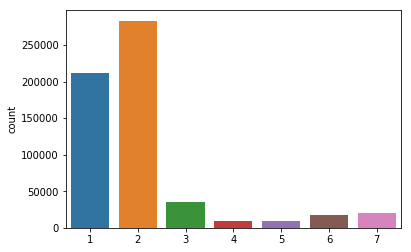

In [7]:
# SMOTE for oversampling class number 4 to include as many observations as class 5 (new minority class)
sm = SMOTE(sampling_strategy={4: 9493}, random_state=random_state)
X_resampled, y_resampled = sm.fit_resample(X, y)

sns.countplot(y_resampled);

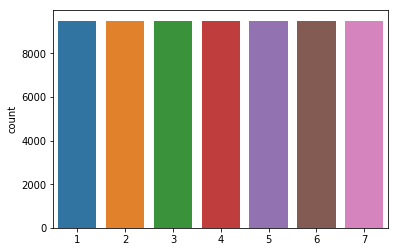

In [8]:
from imblearn.under_sampling import RandomUnderSampler

# Randomly undersampling rest of the classes
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=random_state)
X_rus, y_rus = rus.fit_sample(X_resampled, y_resampled)

sns.countplot(y_rus);

All classes are now sampled, now we can explore feature distributions again.

In [9]:
X = pd.DataFrame(X_rus, columns=labels)
y = pd.DataFrame(y_rus, columns=['Cover_Type'])

In [ ]:
X[numerical].describe()

In [ ]:
X[numerical].hist(figsize=(16, 20), bins=50);

In [ ]:
# Extracting binary feature column names
binary = X.iloc[:,10:54].columns.values.tolist()

# Counting binary variables
counts = X[binary][X[binary] == 1].count()

fig, ax = plt.subplots(figsize=(20, 15))
plt.barh(counts.index, counts.iloc[0:])
plt.xlabel('Count')
plt.title('Binary variables after sampling')
plt.show()

 Next we can plot correlation matrix to study correlations

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(h_neg=210, h_pos=350, as_cmap=True)

# Calculate correlations
corr = data[numerical].corr()

ax = sns.heatmap(data=corr, vmin=0, vmax=1, square=True, cmap=cmap)
ax.set(title='Correlation Matrix')
plt.show()

There seems not to be too high correlation between variables, which is good for classifier performance. All features have some value in constructing the model.

## Unsupervised Learning

As we now true classes of the dataset (ground truth) we can use adjusted rand index (ARI) and Silhouette score as the clustering performance metric. We will use sum of squared errors (inertia) as metric for finding experimental number of clusters for our algorithm.

In [10]:
X = X.values
y = y.values

### KMeans Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler

# Standardizing data for clustering
X_std = StandardScaler().fit_transform(X.astype('float64'))

In [ ]:
# List for storing sum of squared errors for different kmeans models
sse = []

for i in np.arange(1,101,5):
    kmeans = KMeans(n_clusters=i, random_state=random_state).fit(X_std)
    sse.append(kmeans.inertia_)

In [ ]:
plt.plot(np.arange(1,101,5), sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

It looks like that k=45 might be good choice for the number of clusters when looking at the elbow plot

In [ ]:
kmeans = KMeans(n_clusters=45, random_state=random_state).fit(X_std)
labels_pred = kmeans.labels_

print("Silhouette score: ", silhouette_score(X, labels_pred))
print("Adjusted Rand index: ", adjusted_rand_score(y.ravel(), labels_pred))

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. It gives values from 0 to 1.

The best value for silhouette score is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

From these results we can infer that the clustering is not that succesfull. Our data is high-dimensional which probably affects clustering results through curse of dimensionality.

## Supervised Learning

## Train/Test split

In [13]:
from sklearn.model_selection import train_test_split

# Sizes of different sets
test_size = 0.2
train_size = 0.8

trnX, tstX, trnY, tstY = train_test_split(X, y, test_size=test_size, random_state=random_state)

## Classification

We will be using RandomizedSearchCV for tuning hyperparameters and finding roughly best performing parameters for our models. Because target classes are balanced, we can use accuracy score (default scoring method of most classifiers) for finding these hyperparameters.

In [11]:
# Importing necessary packages and algorithms
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelBinarizer, label_binarize

from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### Naive Bayes

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.

In [ ]:
gnb = cross_val_score(GaussianNB(), trnX, trnY.ravel(), cv=5)

print("Classifier accuracy: %0.4f (+/- %0.4f)" % (gnb.mean(), gnb.std() * 2))

Classifier accuracy: 0.5988 (+/- 0.0057)

### KNN

In [ ]:
grid = {'n_neighbors':[5, 10, 15, 20, 25, 30],
        'metric':['minkowski', 'manhattan']}

knn = RandomizedSearchCV(KNeighborsClassifier(), 
                         grid, cv=5, n_iter=10,
                         random_state=random_state)

knn.fit(trnX, trnY.ravel())

print("Classifier best score: %.4f for parameters: %s" % (knn.best_score_.mean(), knn.best_params_))

Classifier best score: 0.8843 for parameters: {'n_neighbors': 5, 'metric': 'minkowski'}

### Desicion Tree

In [ ]:
grid = {'criterion':['gini', 'entropy'],
        'min_samples_split': [3, 5, 7, 9, 11, 13, 15],
        'min_samples_leaf': [3, 5, 7, 9, 11, 13, 15],
        'max_depth': np.arange(3, 15, 1)}

dtc = RandomizedSearchCV(DecisionTreeClassifier(),
                         grid, cv=5, n_iter=10,
                         random_state=random_state)

dtc.fit(trnX, trnY)

print("Classifier best score: %.4f for parameters: %s" % (dtc.best_score_.mean(), dtc.best_params_))

Classifier best score: 0.8408 for parameters: {'min_samples_split': 9, 'min_samples_leaf': 3, 'max_depth': 14, 'criterion': 'entropy'}

### RandomForest

In [ ]:
grid = {'n_estimators': np.arange(10, 300, 10),
        'max_features': ['auto', 'sqrt'],
       'max_depth': np.arange(1, 15, 1),
        'min_samples_split': np.arange(2, 15, 1)}

rfc = RandomizedSearchCV(RandomForestClassifier(),
                         grid, cv=5, n_iter=10,
                         random_state=random_state)

rfc.fit(trnX, trnY.ravel())

print("Classifier best score: %.4f for parameters: %s" % (rfc.best_score_.mean(), rfc.best_params_))

Classifier best score: 0.8421 for parameters: {'n_estimators': 290, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 12}

### XGBoost

In [15]:
xgb_clf = XGBClassifier(learning_rate=0.2, n_estimators=100, max_depth=10, seed=random_state, n_jobs=-1)

print('Mean cross-validation score: ', np.mean(cross_val_score(xgb_clf, trnX, trnY.ravel(), cv=5)))

Mean cross-validation score:  0.9164411936785946


Mean cross-validation score:  0.9164411936785946

## Model Selection

Based on the cross validation scores of training, we choose KNN as our classifier. Next we need to test how it performs on the test set. 

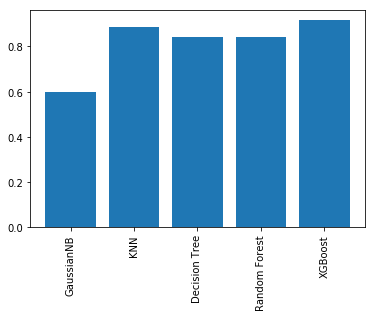

In [16]:
# Plotting results
results = {'GaussianNB':0.5988, 'KNN':0.8843, 'Decision Tree':0.8408, 'Random Forest':0.8421, 'XGBoost':0.9164}

plt.bar(range(len(results)), list(results.values()), align='center')
plt.xticks(range(len(results)), list(results.keys()), rotation='vertical')
plt.show()

## Model Evaluation

In [ ]:
# Labels for confusion matrix
labels = ['Spruce', 'Lodgepole', 'Ponderosa', 'Cottonwood', 'Aspen', 'Douglas-fir', 'Krummholz']

# Function for plotting the confusion matrix
def plot_cnf_mtx(cnf_mtx):
    fig, ax = plt.subplots(figsize=(12, 9))
    ax = sns.heatmap(cnf_mtx, annot=True, fmt="d", cbar=False, cmap='Blues', square=True)
    ax = ax.set(title='Confusion Matrix', xlabel='Predicted Label',
                ylabel='True Label', xticklabels=np.arange(1,8,1),
                yticklabels=np.arange(1,8,1))

# Function for multiclass ROC AUC
def multiclass_roc_auc_score(tstY, prdY, average="macro"):
    lb = LabelBinarizer().fit(tstY)
    tstY = lb.transform(tstY)
    prdY = lb.transform(prdY)
    return roc_auc_score(tstY, prdY, average=average)

### KNearestNeighbors

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
knn.fit(trnX, trnY.ravel())
prdY = knn.predict(tstX)

print('Testing Accuracy score:  %.4f' % accuracy_score(tstY, prdY))
print('Testing ROC AUC score:  %.4f' % multiclass_roc_auc_score(tstY, prdY))

cnf_mtx = confusion_matrix(tstY, prdY)
plot_cnf_mtx(cnf_mtx)

We can see that KNN had the best performance out of every model we tried out! We can try to use GridSearchCV for further hyperparameter tuning to see if it has any effect on model performance.

### KNN Further tuning

In [ ]:
grid = {'n_neighbors':np.arange(3,16,1),
        'metric':['minkowski']}

knn = GridSearchCV(KNeighborsClassifier(), grid, cv=5)

knn.fit(trnX, trnY.ravel())

print("Classifier best score: %.4f for parameters: %s" % (knn.best_score_.mean(), knn.best_params_))

Classifier best score: 0.8988 for parameters: {'metric': 'minkowski', 'n_neighbors': 3}

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, metric='minkowski')
knn.fit(trnX, trnY.ravel())
prdY = knn.predict(tstX)

print('Testing Accuracy score:  %.4f' % accuracy_score(tstY, prdY))
print('Testing ROC AUC score:  %.4f' % multiclass_roc_auc_score(tstY, prdY))

cnf_mtx = confusion_matrix(tstY, prdY)
plot_cnf_mtx(cnf_mtx)

In [ ]:
# Plotting ROC curve

# Binarize the output
y = label_binarize(y, classes=[1,2,3,4,5,6,7])
n_classes = y.shape[1]

trnX, tstX, trnY, tstY = train_test_split(X, y, test_size=test_size, random_state=random_state)

y_score = knn.predict_proba(tstX)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(tstY[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(tstY.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12, 9))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multiclass prediction')
plt.legend(loc="lower right")
plt.show()

Further hyperparameter tuning was effective, we were able to increase the accuracy of the model from 0.893 to 0.906. One thing that can still be done is normalization of numerical variables.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(trnX)
trnX = scaler.transform(trnX)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, metric='minkowski')
knn.fit(trnX, trnY.ravel())

# Apply scaler to test data
tstX = scaler.transform(tstX)

prdY = knn.predict(tstX)

print('Accuracy:', accuracy_score(tstY, prdY))

Scaling numerical features to range 0 to 1 seems to hinder the performance of the classifier a bit (0.9057 -> 0.8812). This might be due to not optimal hyperparameters for the scaled data.